<a href="https://colab.research.google.com/github/anaaaraujoo/deepfake-detection/blob/main/HybridDeepfakeDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Installing all the necessary libraries and frameworks
!pip install -q facenet-pytorch tensorflow matplotlib seaborn scikit-learn opencv-python pandas numpy tqdm pytorch-lightning timm gdown

In [20]:
# Importing all the necessary libraries
import os
import cv2
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torch.utils import data as data
from facenet_pytorch import MTCNN
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [21]:
# Downloading and unziping the dataset - CelebDF
from google.colab import drive
import zipfile
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/Celeb-DF.zip'
extract_path = '/content'
zip_ref = zipfile.ZipFile(dataset_path, 'r')
zip_ref.extractall(extract_path)
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Real Samples: 


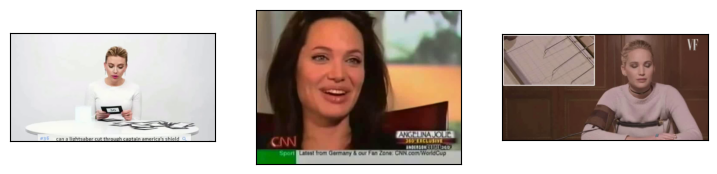

Fake Samples: 


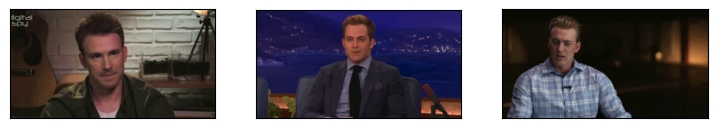

In [22]:
# Plotting some samples for visual comprehension
real_path = '/content/Celeb-real'
fake_path = '/content/Celeb-synthesis'
real_videos = [os.path.join(real_path, f) for f in os.listdir(real_path) if f.endswith(".mp4")]
fake_videos = [os.path.join(fake_path, f) for f in os.listdir(fake_path) if f.endswith(".mp4")]

n = 3 # Samples to plot per class

def extract_first_frame(video_path):
  cap = cv2.VideoCapture(video_path)
  ret, frame = cap.read()
  cap.release()
  return frame

i = 1
print('Real Samples: ')
plt.rcParams['figure.figsize'] = [9, 9]
for video in real_videos[:n]:
  ax = plt.subplot(3, n, i)
  frame = extract_first_frame(video)
  plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  i += 1
plt.show()

print('Fake Samples: ')
plt.rcParams['figure.figsize'] = [9, 9]
for video in fake_videos[:n]:
  ax = plt.subplot(3, n, i)
  frame = extract_first_frame(video)
  plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  i += 1
plt.show()

In [32]:
# Frame extractor and face recognition functions
max_frames = 30
def frame_extractor(video_path):
  frames = []
  cap = cv2.VideoCapture(video_path)
  frame_count = 0
  while True:
    ret, frame = cap.read()
    if not ret or frame_count >= max_frames:
      break
    frame = cv2.resize(frame, (224, 224))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)
    frame_count += 1
  cap.release()
  return np.array(frames)

# Dividing the data in the train/val/test split
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from sklearn.model_selection import train_test_split

class CelebDF(Dataset):
    def __init__(self, video_paths):
        self.videos = video_paths

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        frames = frame_extractor(str(video_path))
        label = 0 if "real" in str(video_path) else 1
        return frames, label

# ---------------------------------------------
# Create train/val/test splits
# ---------------------------------------------
real_videos_root = Path("/content/Celeb-real")
fake_videos_root = Path("/content/Celeb-synthesis")

real_videos = list(real_videos_root.rglob("*.mp4"))
fake_videos = list(fake_videos_root.rglob("*.mp4"))

all_videos = real_videos + fake_videos
print(f"Total number of videos: {len(all_videos)}")

# Create labels for the videos
labels = [0] * len(real_videos) + [1] * len(fake_videos)

# Split the data into train, validation, and test sets
train_videos, test_videos, train_labels, test_labels = train_test_split(all_videos, labels, test_size=0.2, random_state=42, stratify=labels)
train_videos, val_videos, train_labels, val_labels = train_test_split(train_videos, train_labels, test_size=0.25, random_state=42, stratify=train_labels) # 0.25 * 0.8 = 0.2

train_data = CelebDF(train_videos)
val_data   = CelebDF(val_videos)
test_data  = CelebDF(test_videos)

# Example DataLoader (batch_size=4)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False, num_workers=4)

print(f"Number of training videos: {len(train_data)}")
print(f"Number of validation videos: {len(val_data)}")
print(f"Number of testing videos: {len(test_data)}")

Total number of videos: 953
Number of training videos: 571
Number of validation videos: 191
Number of testing videos: 191


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  with torch.autograd.profiler.record_function(self._profile_name):
